<a href="https://colab.research.google.com/github/MiguelAngel-ht/Quantum-Computing/blob/main/Quantum_Fourier_Transform_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" f24e14910e231e248b0cb7292bca6a947a8ae0d4b45803efcbed611670897d58b18b002d4300c4eb742c9e22dc4508ece9469c1f3ea3ac1315b8e56c97eacaed 
""" # My token

In [1]:
from google.colab import output     # clear output when is not necessary
!pip install qiskit                   
!pip install qiskit[visualization]   # Qiskit to parameter "mpl" works in colab
output.clear()

In [11]:
# Import qiskit_textbook.widgets 

!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
output.clear()

In [2]:
from numpy import pi

# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [13]:
from qiskit_textbook.widgets import scalable_circuit

In [61]:
def qft_rotations(circuit, n):
    if n == 0:                  # Exit function if circuit is empty
        return circuit
    n -= 1                      # Indexes start from 0
    circuit.h(n)                # Apply the H-gate
    for qubit in range(n): 
        circuit.cp(pi / (2**(n-qubit)), qubit, n)
    qft_rotations(circuit, n)

In [62]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [64]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""

    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])

    return circuit.decompose() # .decompose() allows us to see the individual gates

In [69]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

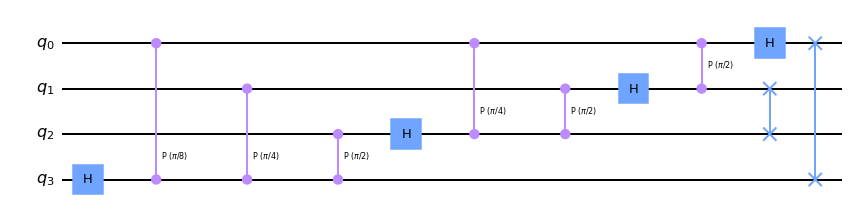

In [70]:
# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw("mpl")

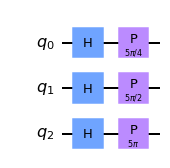

In [71]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw("mpl")

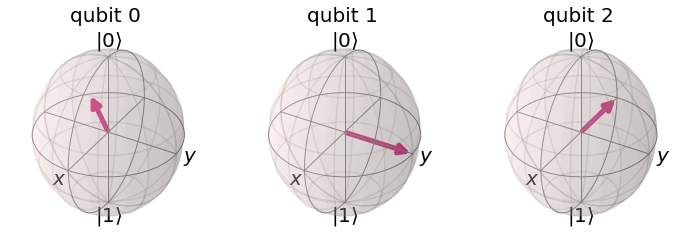

In [72]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

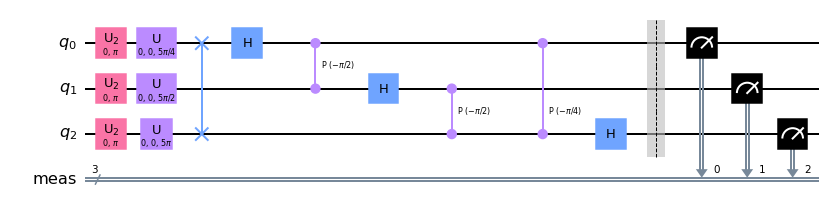

In [73]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw("mpl")

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.save_account("f24e14910e231e248b0cb7292bca6a947a8ae0d4b45803efcbed611670897d58b18b002d4300c4eb742c9e22dc4508ece9469c1f3ea3ac1315b8e56c97eacaed")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))

In [82]:
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [75]:
shots = 5000
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


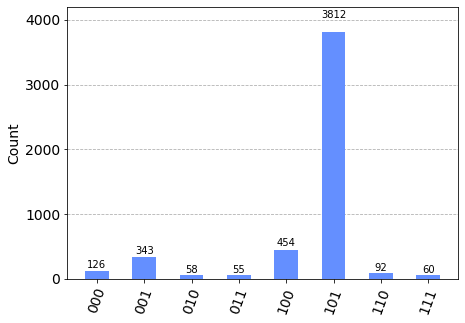

In [77]:
counts = job.result().get_counts()
plot_histogram(counts)